<a href="https://colab.research.google.com/github/acse-rt1120/test/blob/main/%E2%80%9C%E2%80%9CPractical6_VariationalAutoEncoder_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC%E2%80%9DaddAdam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Morning Session 6: Autoencoders and Variational Autoencoders**

# Introduction

In this session you will implement two simple generative models. The first will be an Autoencoder, and the second a Variational Autoencoder, both will generate handwritten digits from MNIST. 

The code is based on a resource by Alexander Van de Kleut https://avandekleut.github.io/vae/ who introduces Autoencoders and then Variational Autoencoders (VAE's).


# 0 Preliminaries

## 0.1 Mount Google-drive

We start by mounting Google-drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0.2 Import libraries

We will need the following libraries


In [ ]:
%pip install numpy cython
%pip install POT

     |████████████████████████████████| 440kB 3.9MB/s 


In [ ]:
%matplotlib inline
import numpy as np
import pylab as pl
import ot

In [2]:
import torch  # Pytorch
import torch.nn as nn  # Neural network module
import torch.nn.functional as fn  # Function module
from torchvision import datasets  # Datasets from torchvision
from torchvision import transforms  # Transforms from torchvision

import matplotlib.pyplot as plt  # Plotting using matplotlib
import numpy as np  # Numpy
from numpy import linalg
device = 'cuda'  # Set out device to GPU

print('done')  # Let me know this cell has finished

done


## 0.3 Load MNIST

We load the MNIST data-set


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


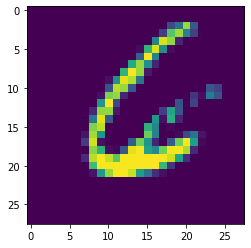

number of batches = 60000
number of images = 60000


In [3]:
# MNIST Test dataset and dataloader declaration
batch_size = 1
data = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([transforms.ToTensor(),])
                   ),
                   batch_size=batch_size, shuffle=True) # Load MNIST. Use the Data Loader to shuffle and batch images

images, labels = next(iter(data)) # A trick for getting a batch out of the dataloader object
plt.imshow(images[0].squeeze()) # Show the first image from the batch
plt.show()
data_size = len(data)*batch_size
print('number of batches = '+str(len(data))) # Print num batches
print('number of images = '+str(len(data)*batch_size)) # Print num images


# 1 The Autoencoder

This tutorial will teach you to build an **Autoencoder** which is capable of generating handwritten digits after training on the MNIST dataset. 

This week you have seen that Generative Models capture the joint probability distribution of an observed and a latent variable. An Autoencoder is a "Deep Generative Model" where an observed variable is transformed to a latent space using an "Enconder" neural network, and the latent space is transformed back to the observed variable space using a "Decoder" neural network. The following diagram shows this visually

![AE_Diagram_nNotation.jpg](https://raw.githubusercontent.com/acse-2020/ACSE-8/main/implementation/practical_6/morning_lecture/Figs/AE_Diagram_nNotation.jpg?token=ABNZJP6ABPKKONEYSYWHBILAU22L4)


## 1.1 Questions

From the diagram above, which symbol represents the observed variable?

1. $X \quad$     2. $\hat{X}  \quad$   3. $\phi  \quad$   4. $\theta  \quad$   5.   $z  \quad$

From the diagram above, which symbol represents the latent variable?

1. $X \quad$     2. $\hat{X} \quad$   3. $\phi \quad$   4. $\theta \quad$   5.   $z \quad$

What are the parameters of the encoder and decoder (remembering that both are deep neural networks?)

1. The weights $\ w_{ij}$
2. The biases $\ b_j$
3. The activations $a_j$
4. The output of the final layer $a^L_j$

## 1.2 Encoder

Auto-encoders use an encoder-decoder framework, where the encoder and decoder are neural networks. We will build an Autoencoder where the Encoder network and the Decoder network have 2 fully-connected layers.

The architecture of the Encoder is as follows:

1. The input layer: 784 nodes (becuase the MNIST images are 28x28 pixels)
2. The first layer: 512 nodes
3. The second: 256 nodes

Use ReLU for your activation function.

The outline of the encoder module is below, complete the following exercises

---

*To learn more about PyTorch neural network modules* https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html

In [4]:
class Encoder(nn.Module):  # The Encoder inherits the properties of nn.Module https://pytorch.org/docs/stable/generated/torch.nn.Module.html
  def __init__(self):
    '''
    Class contains the Encoder (image -> latent).
    '''

    super(Encoder, self).__init__()
    self.layer0 = nn.Linear(784, 512)  # Image to hidden, fully connected
    self.transform0 = nn.ReLU()
    self.layer1 = nn.Linear(512, 256)  # Image to hidden, fully connected
    self.transform1 = nn.ReLU()

  def forward(self, x):  # Custom pytorch modules should follow this structure 
    '''
    x: [float] the MNIST image
    '''

    x = torch.flatten(x, start_dim = 1)  # Reshape the input into a vector (nD to 1D) 
    x = self.transform0(self.layer0(x))  # Run Image through Linear transform then ReLu activation function
    x = self.transform1(self.layer1(x))  # Run Image through Linear transform then ReLu activation function
    return x
  
  print('done') # Show when the module has run

done


## 1.3 Decoder

The decoder will have the same architecture as the decoder but in reverse. Therefore

2. The first layer: 256 nodes
3. The second layer: 512 nodes
4. The output layer will have 784 nodes.

Again, use ReLU activations, apart from the output layer which will use a Sigmoid acitvations (because MNIST images pixel valeus are between 0 and 1).

In [5]:
class Decoder(nn.Module):
  def __init__(self):
    '''
    Class contains the Decoder (latent -> image).
    '''

    super(Decoder, self).__init__()
    self.layer1 = nn.Linear(256, 512)  # Connectivity Latent to Hidden
    self.activation1 = nn.ReLU()
    self.layerOut = nn.Linear(512, 784)  # Connectivity Hidden to Image
    self.activationOut = nn.Sigmoid()

  def forward(self, z):
    '''
    z: [float] a sample from the latent variable
    '''

    z = self.activation1(self.layer1(z))  # Run Image through Linear transform then ReLu activation function
    z = self.activationOut(self.layerOut(z))  # Run Image through Linear transform then Sigmoid activation function
    return  z.reshape((-1,1,28,28))  # Reshape the vector into an image

print('done')

done


## 1.4 Autoencoder

The Autoencoder structure inherits from the Encoder and the Decoder. This is done by "dependency injection" (where the Enconder and Decoder class are assigned to properties of the Autoencoder). The forward module of the Autoencoder should take and image, run the Encoder (image -> latent) then run the Decoder to make a prediction (latent -> generated image).

The Autoencoder is below, and the latent space will have variable dimensionality.



In [6]:
class Autoencoder(nn.Module):
  def __init__(self, dims_latent):
    '''
    Class combines the Encoder and the Decoder with an Autoencoder latent space.

    dims_latent: [int] the dimension of (number of nodes in) the mean-field gaussian latent variable
    '''

    super(Autoencoder, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()

    self.latentIn = nn.Linear(256, dims_latent)  # Hidden to latent, fully connected
    self.latentOut = nn.Linear(dims_latent, 256)  # Connectivity Latent to Hidden
    self.activationOut = nn.ReLU()

  def forward(self, x):
    '''
    x - [float] A batch of images from the data-loader
    '''

    x = self.encoder(x)  # Run the image through the Encoder
    z =  self.latentIn(x)  # Take the output of the encoder and get the latent vector 
    z = self.activationOut(self.latentOut(z))  # Take the latent vector and make the input for the Decoder
    return self.decoder(z)  # Return the output of the decoder (the predicted image)

print('done')

done


In [ ]:
def train(autoencoder, data, kl_div_on=True, epochs=10):
  opt = torch.optim.Adam(autoencoder.parameters())
  for epoch in range(epochs):  # Run data over numerous epochs
    for batch, label in data:  # Iterate over the batches of images and labels
      batch = batch.to(device)  # Send batch of images to the GPU
      opt.zero_grad()  # Set optimiser grad to 0
      x_hat = autoencoder(batch)  # Generate predicted images (x_hat) by running batch of images through autoencoder
      loss = ((batch - x_hat)**2).sum()  # Calculate L2 loss
      loss.backward()  # Back-propagate
      opt.step()  # Step the optimiser
  return autoencoder  # Return the trained autoencoder (for later analysis)


dims_latent = 2  # Maybe increase this an try the t-sne algorithm for visualisation?!
autoencoder0 = Autoencoder(dims_latent).to(device)
autoencoder0 = train(autoencoder0, data, 10)

print('done')

done


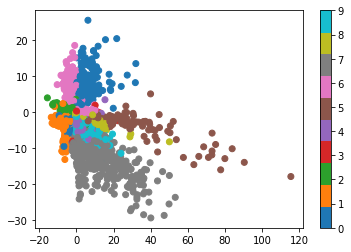

tensor([0, 6, 8, 7, 8, 6, 5, 6, 2, 6, 7, 2, 7, 9, 2, 2, 8, 0, 8, 3, 9, 2, 6, 2,
        4, 5, 2, 3, 8, 6, 8, 7, 6, 3, 8, 2, 9, 5, 8, 8, 2, 6, 7, 9, 6, 7, 1, 4,
        4, 7])
tensor(0)


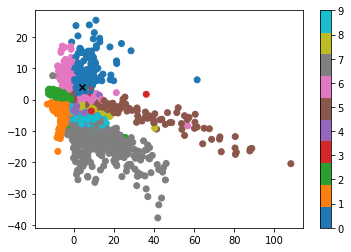

In [ ]:
def plot_2D_latent_space(autoencoder, data, num_batches=100):
    '''
    Plot a the latent vector for a lots of images
    '''
    for n , (x, y) in enumerate(data):  # enumerate means n = n + 1 per iteration. x is the batch of images, y are the class labels
        z = autoencoder.latentIn(autoencoder.encoder(x.to(device)))  # Run the batch through the Encoder and Latent input layer
        z = z.to('cpu').detach().numpy()  # Send latent vector to cpu
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')  # Scatter plot of latent vector colourised by the class label y
        if n > num_batches:  # stop after n > maximum number of batches
          plt.colorbar()
          break

def plot_2D_latent_sample(autoencoder, image):
    '''
    Plot a the latent vector for a single image
    '''
    z = autoencoder.latentIn(autoencoder.encoder(image.to(device)))  # Run the image through the Encoder and Latent input layer
    z = z.to('cpu').detach().numpy()  # Send latent vector to cpu
    plt.scatter(z[:, 0], z[:, 1], marker='x', c='k')  # Scatter plot of latent vector

plot_2D_latent_space(autoencoder0, data)
plt.show()

x,y = next(iter(data)) # Get next iteration from data iterator
print(y)

n = 0  # Choose a label
print(y[n]) # Print out chose label

image = x[n]
plt.figure()
plot_2D_latent_space(autoencoder0, data)
plot_2D_latent_sample(autoencoder0, image)

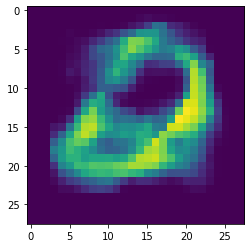

tensor([-10.,   5.], device='cuda:0')


In [ ]:
def plot_sample(autoencoder, z):
    img = autoencoder.decoder(autoencoder.activationOut(autoencoder.latentOut(z))).to('cpu').detach().numpy()[0,0]
    plt.imshow(img)
    plt.show()
    print(z)

z = torch.tensor([-10, 5]).to(device).float()
plot_sample(autoencoder0, z)

In [7]:
dims_latent = 2  # Maybe increase this an try the t-sne algorithm for visualisation?!
autoencoder = Autoencoder(dims_latent).to(device)

In [8]:
print("Model's state_dict:")
layers_num = -1
layer_size = []
for param_tensor in autoencoder.state_dict():
    layers_num += 1
    layer_size.append(list(autoencoder.state_dict()[param_tensor].size()))
    print(param_tensor, "\t", autoencoder.state_dict()[param_tensor].size())

Model's state_dict:
encoder.layer0.weight 	 torch.Size([512, 784])
encoder.layer0.bias 	 torch.Size([512])
encoder.layer1.weight 	 torch.Size([256, 512])
encoder.layer1.bias 	 torch.Size([256])
decoder.layer1.weight 	 torch.Size([512, 256])
decoder.layer1.bias 	 torch.Size([512])
decoder.layerOut.weight 	 torch.Size([784, 512])
decoder.layerOut.bias 	 torch.Size([784])
latentIn.weight 	 torch.Size([2, 256])
latentIn.bias 	 torch.Size([2])
latentOut.weight 	 torch.Size([256, 2])
latentOut.bias 	 torch.Size([256])


In [12]:
print(layer_size[0],data_size)

[512, 784] 60000


In [10]:
def this_layer_grad(layer_size,data_size,layer_num):
    this_layer_grad = torch.zeros((layer_size[0],layer_size[1],batch_size)).to(device)
    print(this_layer_grad.size())
    sample_num = 0
    for batch, label in data:  # Iterate over the batches of images and labels
        batch = batch.to(device)
        for param in autoencoder.parameters():
            param.grad = None
        x_hat = autoencoder(batch)  # Generate predicted images (x_hat) by running batch of images through autoencoder
        loss = ((batch - x_hat) ** 2).sum()  # Calculate L2 loss
        loss.backward()  # Back-propagate
        this_layer = -1
        for param in autoencoder.parameters():
            this_layer += 1
            if this_layer == layer_num :
              this_layer_grad[:,:,sample_num] = param.grad.copy()
        sample_num += 1
        if sample_num >= 100:
          break

    return this_layer_grad

In [ ]:
layer0_grads = this_layer_grad(layer_size[0],data_size,0)

In [ ]:
def this_layer_grad(layer_size,data_size,layer_num,data):

    for batch, label in data:  # Iterate over the batches of images and labels
        batch = batch.to(device)
        #双数层
        this_layer_part_grad = torch.zeros((layer_size[0], layer_size[1], batch_size)).to(device)
        this_layer_part_grad = get_grad_from_this_batch(this_layer_part_grad,batch,batch_size)
        this_layer_part_grad = get_positive_grads(this_layer_part_grad)
        b = Wasserstein_barycentre_even(layer_size, niter, batch_size, this_layer_part_grad)
        #将b保留

    return this_layer_grad


def get_grad_from_this_batch(this_layer_part_grad,batch,layer_num):
    sample_num = 0
    for sample in batch:
        for param in autoencoder.parameters():
            param.grad = None
        x_hat = autoencoder(sample)  # Generate predicted images (x_hat) by running batch of images through autoencoder
        loss = ((sample - x_hat) ** 2).sum()  # Calculate L2 loss
        loss.backward()  # Back-propagate
        this_layer = -1
        for param in autoencoder.parameters():
            this_layer += 1
            if this_layer == layer_num:
                this_layer_part_grad[:, :, sample_num] = param.grad.copy()
        sample_num += 1
    return this_layer_part_grad

def get_positive_grads(input_grad):
    input_grad = input_grad + torch.abs(torch.min(input_grad)).item()
    return input_grad


def Wasserstein_barycentre_even(layer_size, niter, samples_num, this_layer_part_grad):
    t0 = np.linspace(0, 1, layer_size[0])
    [Y0, X0] = np.meshgrid(t0, t0)
    K0 = np.exp(-(X0 - Y0) ** 2 / epsilon)
    K0 = torch.from_numpy(K0).type(torch.FloatTensor).to(device)
    t1 = np.linspace(0, 1, layer_size[1])
    [Y1, X1] = np.meshgrid(t1, t1)
    K1 = np.exp(-(X1 - Y1) ** 2 / epsilon)
    K1 = torch.from_numpy(K1).type(torch.FloatTensor).to(device)
    K = lambda x: (K0 @ x) @ K1
    v = torch.ones((layer_size[0], layer_size[1], samples_num)).to(device)
    u = np.copy(v)
    Err_q = torch.zeros(niter)
    lambd = torch.ones(samples_num) / samples_num
    for i in range(niter):

        for k in range(samples_num):
            Err_q[i] = Err_q[i] + torch.norm(u[:, :, k] * K(v[:, :, k]) - this_layer_part_grad[:,:,k], p=1)
            u[:, :, k] = this_layer_part_grad[:,:,k] / K(v[:, :, k])

        b = torch.zeros((layer_size[0], layer_size[1])).to(device)
        for k in range(samples_num):
            b = b + lambd[k] * torch.log(torch.maximum(1e-19 * torch.ones(np.shape(v[:, :, k])), v[:, :, k] * K(u[:, :, k])))
        b = torch.exp(b)

        for k in range(samples_num):
            v[:, :, k] = b / K(u[:, :, k])

    plt.figure(figsize=(7, 5))
    plt.plot(np.log(Err_q), linewidth=2)
    plt.show()
    return b

In [1]:
def calculate_grads(autoencoder,data,):
    all_grads = []
    i = 0
    temp = 0
    for batch, label in data:  # Iterate over the batches of images and labels
        batch = batch.to(device)
        for sample in batch:
            for param in autoencoder.parameters():
                param.grad = None
            temp += 1
            x_hat = autoencoder(
                sample)  # Generate predicted images (x_hat) by running batch of images through autoencoder
            loss = ((sample - x_hat) ** 2).sum()  # Calculate L2 loss
            loss.backward()  # Back-propagate
            my_grad = []
            j = 0
            for param in autoencoder.parameters():
                # print(param.shape)
                my_grad.append(param.grad.cpu().detach().numpy().copy())
                j += 1
            all_grads.append(my_grad)
        i +=1
        if i>=1:
            break

    return j, len(batch)*i, all_grads

In [ ]:
params_num, samples_num, all_grads = calculate_grads(autoencoder,data)

In [ ]:
#demo
# def train(autoencoder, opt, data, kl_div_on=True, epochs=10):
  
#   j = 0
#   all_grads = []
#   for epoch in range(epochs):  # Run data over numerous epochs
#     for batch, label in data:  # Iterate over the batches of images and labels
#       batch = batch.to(device)  # Send batch of images to the GPU
#       opt.zero_grad()  # Set optimiser grad to 0
#       x_hat = autoencoder(batch)  # Generate predicted images (x_hat) by running batch of images through autoencoder
#       loss = ((batch - x_hat)**2).sum()  # Calculate L2 loss
#       loss.backward()  # Back-propagate
#       opt.step()  # update model parameters using the gradients
#       j += 1
#       i = 0
#       my_grad = []
#       for param in autoencoder.parameters():
#         #print(param.shape)
#         my_grad.append(param.grad.cpu().detach().numpy().copy()) 
#         i +=1
#       all_grads.append(my_grad)

    
#       if j>=50:
#         break
#   return i, j, all_grads



In [ ]:
# params_num, samples_num, all_grads = train(autoencoder,opt, data, epochs=1)
# # print(all_grads[0][2]==all_grads[4][2])
# # plt.figure(figsize = (10,10))
# # im = plt.imshow(all_grads[0][2], cmap='seismic', vmin=-0.1, vmax=0.1)
# # plt.colorbar(im,fraction=0.044, pad=0.1)

In [ ]:
# 所有local gradients的集合
new_all_grads = []
for num in range(samples_num):
  #每个sample的gradient的集合
  new_sample_grad = []
  for nump in range(0, params_num, 2):
    #把weights和bais合并
    new_param_grad = np.zeros((np.shape(all_grads[num][nump])[0], np.shape(all_grads[num][nump])[1]+1))
    for i in range(np.shape(all_grads[num][nump])[0]):
      for j in range(np.shape(all_grads[num][nump])[1]):
        new_param_grad[i][j] = all_grads[num][nump][i][j]
    for i in range(np.shape(all_grads[num][nump])[0]):
      new_param_grad[i][-1] = all_grads[num][nump+1][i]
    new_sample_grad.append(new_param_grad)
  new_all_grads.append(new_sample_grad)


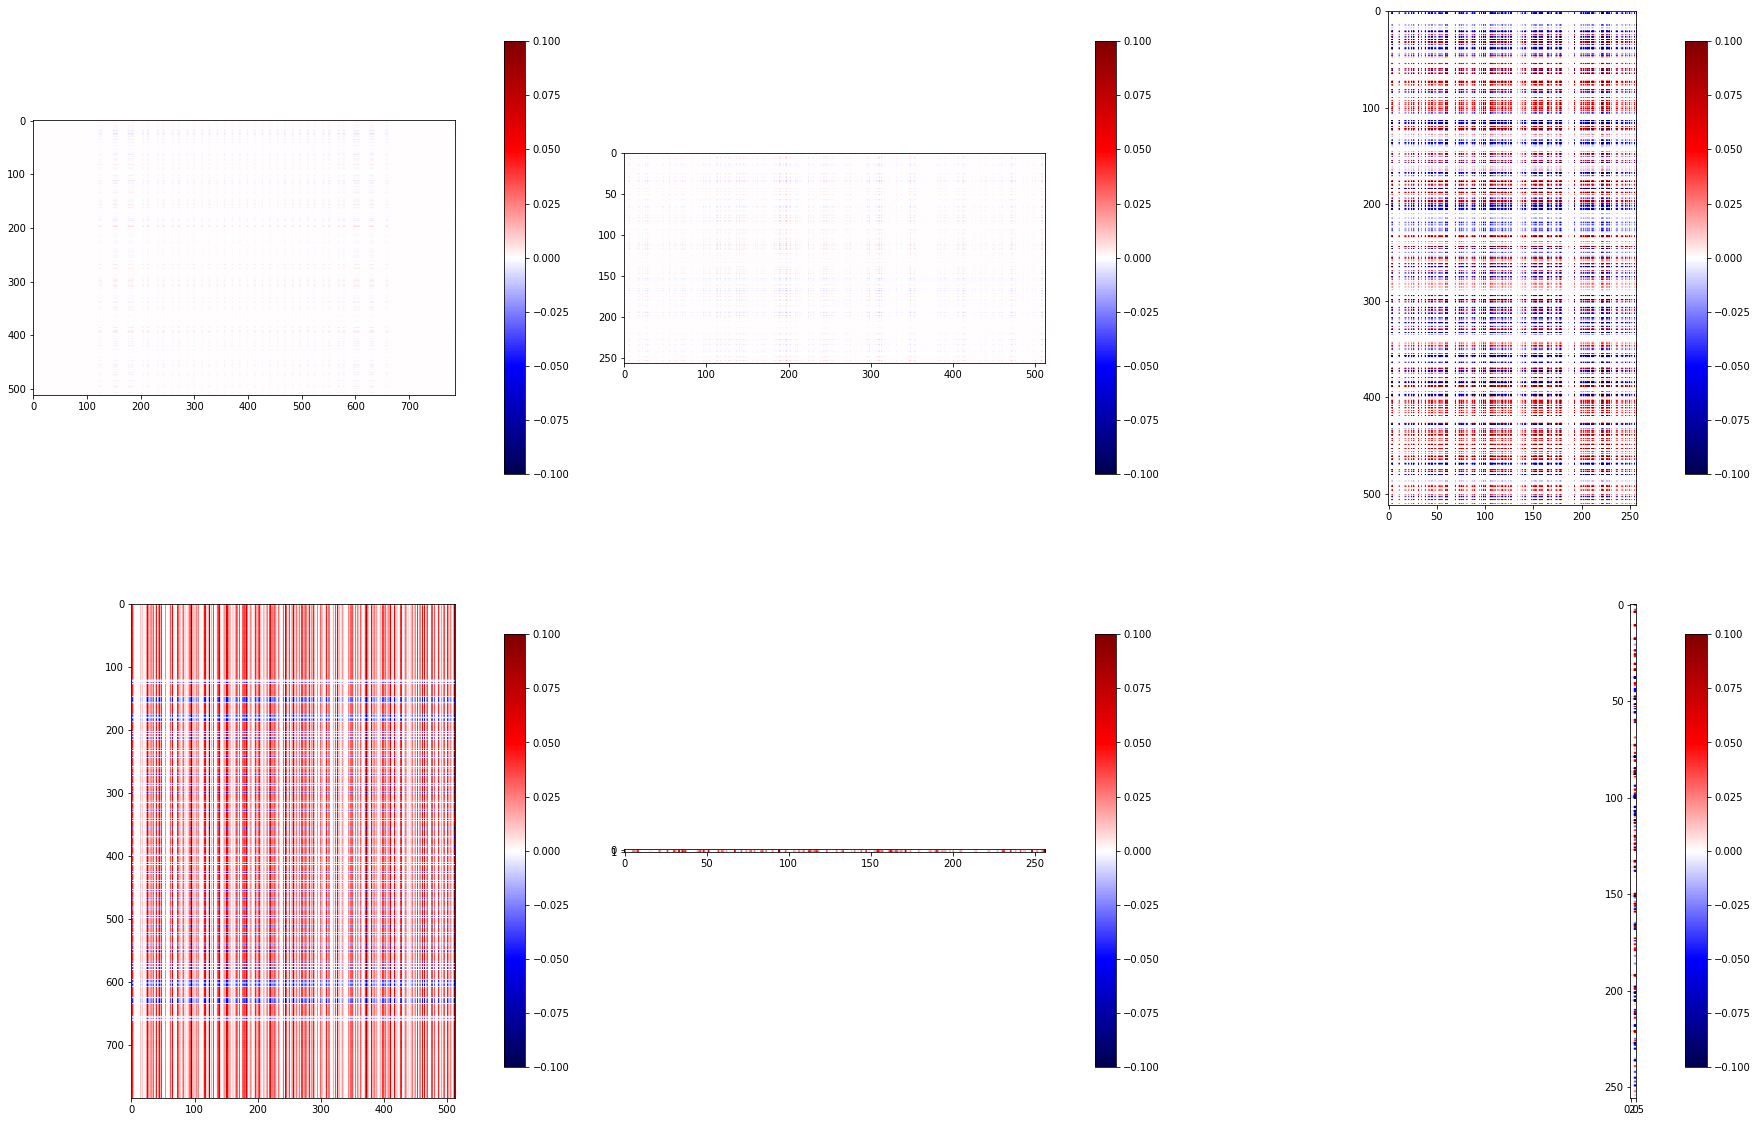

In [ ]:
#sample 0
fig, axes = plt.subplots(2,3,figsize=(30,20))
for nump in range(int(params_num/2)):
  i = int(nump/3)
  j = int(nump%3)
  im = axes[i,j].imshow(new_all_grads[0][nump], cmap='seismic', vmin=-0.1, vmax=0.1)
  plt.colorbar(im,fraction=0.044, pad=0.1,ax =axes[i,j] )


In [ ]:
#sample 1
fig, axes = plt.subplots(2,3,figsize=(30,20))
for nump in range(int(params_num/2)):
  i = int(nump/3)
  j = int(nump%3)
  im = axes[i,j].imshow(new_all_grads[1][nump], cmap='seismic', vmin=-0.1, vmax=0.1)
  plt.colorbar(im,fraction=0.044, pad=0.1,ax =axes[i,j] )

In [ ]:
#sample 0~48 with element0
fig, axes = plt.subplots(7,7,figsize=(70,70))
for num in range(49):
  i = int(num/7)
  j = int(num%7)
  im = axes[i,j].imshow(new_all_grads[num][0], cmap='seismic', vmin=-0.1, vmax=0.1)
  plt.colorbar(im,fraction=0.044, pad=0.1,ax =axes[i,j] )

In [ ]:
#sample 0~3 with element0
fig, axes = plt.subplots(2,2,figsize=(20,20))
for num in range(4):
  i = int(num/2)
  j = int(num%2)
  im = axes[i,j].imshow(new_all_grads[num][0], cmap='seismic', vmin=-0.1, vmax=0.1)
  plt.colorbar(im,fraction=0.044, pad=0.1,ax =axes[i,j] )

In [ ]:
# #demo
# # 所有local gradients的集合
# new_4_grads = []
# for num in range(4):
#   #每个sample的gradient的集合
#   new_sample_grad = []
#   for nump in range(0, params_num, 2):
#     #把weights和bais合并
#     new_param_grad = np.zeros((np.shape(all_grads[num][nump])[0], np.shape(all_grads[num][nump])[1]+1))
#     for i in range(np.shape(all_grads[num][nump])[0]):
#       for j in range(np.shape(all_grads[num][nump])[1]):
#         new_param_grad[i][j] = all_grads[num][nump][i][j]
#     for i in range(np.shape(all_grads[num][nump])[0]):
#       new_param_grad[i][-1] = all_grads[num][nump+1][i]
#     new_sample_grad.append(new_param_grad)
#   new_4_grads.append(new_sample_grad)

In [ ]:
def get_positive_grads(input_grad):
    input_grad = input_grad + torch.abs(torch.min(input_grad)).item()
    return input_grad

In [ ]:
def all_positive(new_all_grads, sample_num, params_num):
  local_mins = []
  for j in range(int(params_num/2)):
      for i in range(sample_num):
          local_min = new_all_grads[i][j].min()
          local_mins.append(local_min)
  global_min = min(local_mins)
  for j in range(int(params_num / 2)):
      for i in range(sample_num):
          new_all_grads[i][j] = new_all_grads[i][j] + np.abs(global_min)
          #print("minimum in every sample: ", new_all_grads[i][j].min())

  return global_min

In [ ]:
global_min = all_positive(new_all_grads,samples_num, params_num)

In [ ]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
import pylab as pyl

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

error in log-plot.

正则化鼓励利用多数小流量路径的传输，而惩罚稀疏的，利用少数大流量路径的传输，由此达到减少计算复杂度的目的。

可以看到，在ε取值较低时，传输集中使用少数路径，然而当ε取值变大，正则化传输的最优解变得更加“扁平”，使用更多的路径进行传输。


In [ ]:
def max_tensor(a, b):
    a = a.numpy()
    b = b.cpu().detach().numpy().copy()
    c = np.maximum(a,b)
    c = torch.from_numpy(c).type(torch.FloatTensor).to(device)
    return c


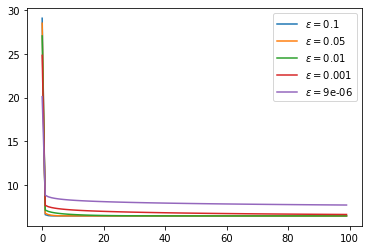

In [ ]:
def Wasserstein_barycentre_find_epsilon(epsilon, layer_num, niter, samples_num, new_all_grads):
    # if layer_num != 4:
    #     epsilon = (.003) ** 2
    # else:
    #     epsilon = (.06) ** 2
    N0 = np.shape(new_all_grads[0][layer_num])[0]
    N1 = np.shape(new_all_grads[0][layer_num])[1]
    t0 = np.linspace(0,1,N0)
    [Y0,X0] = np.meshgrid(t0,t0)
    K0 = np.exp(-(X0-Y0)**2/epsilon)
    K0 = torch.from_numpy(K0).type(torch.FloatTensor).to(device)
    t1 = np.linspace(0,1,N1)
    [Y1,X1] = np.meshgrid(t1,t1)
    K1 = np.exp(-(X1-Y1)**2/epsilon)
    K1 = torch.from_numpy(K1).type(torch.FloatTensor).to(device)
    K = lambda x: (K0 @ x) @ K1
    KT = lambda x: (K0.T @ x) @ K1.T
    v = np.ones([N0, N1, samples_num])
    u = np.copy(v)
    v = torch.from_numpy(v).type(torch.FloatTensor).to(device)
    u = torch.from_numpy(u).type(torch.FloatTensor).to(device)
    Err_q = torch.zeros(niter)
    lambd = torch.ones(samples_num)/samples_num



    for i in range(niter):

        for k in range(samples_num):
            a = torch.from_numpy(new_all_grads[k][layer_num]).type(torch.FloatTensor).to(device)
            Err_q[i] = Err_q[i] + torch.norm(u[:, :, k] * K(v[:, :, k]) - a, p=1)
            u[:, :, k] = a / K(v[:, :, k])

        b = torch.zeros((N0, N1)).to(device)
        for k in range(samples_num):
            b = b + lambd[k] * torch.log(max_tensor(1e-19 * torch.ones(np.shape(v[:, :, k])), v[:, :, k] * KT(u[:, :, k])))
        b = torch.exp(b)

        for k in range(samples_num):
            v[:, :, k] = b / KT(u[:, :, k])
    #plt.figure(figsize=(7, 5))
    plt.plot(np.log(Err_q), label='$\epsilon=$' + str(epsilon))
    plt.legend();


    return b
for epsilon in (.1, .05, .01, .001,(.003)**2):
    b= Wasserstein_barycentre_find_epsilon(epsilon=epsilon,layer_num=0,niter=100,samples_num=samples_num, new_all_grads=new_all_grads)



In [ ]:
def Wasserstein_barycentre_find_epsilon(epsilon, layer_num, niter, samples_num, new_all_grads):
    # if layer_num != 4:
    #     epsilon = (.003) ** 2
    # else:
    #     epsilon = (.06) ** 2
    N0 = np.shape(new_all_grads[0][layer_num])[0]
    N1 = np.shape(new_all_grads[0][layer_num])[1]
    t0 = np.linspace(0, 1, N0)
    t1 = np.linspace(0, 1, N1)
    [Y, X] = np.meshgrid(t0, t1)
    K1 = np.exp(-(X - Y) ** 2 / epsilon)
    K = lambda x: (x @ K1) @ K1.T
    v = np.ones([N0, N1, samples_num])
    u = np.copy(v)
    Err_q = np.zeros(niter)
    lambd = np.ones(samples_num)/samples_num

    for i in range(niter):

        for k in range(samples_num):
            Err_q[i] = Err_q[i] + linalg.norm(u[:, :, k] * K(v[:, :, k]) - new_all_grads[k][layer_num], 1)
            u[:, :, k] = new_all_grads[k][layer_num] / K(v[:, :, k])

        b = np.zeros((N0, N1))
        for k in range(samples_num):
            b = b + lambd[k] * np.log(np.maximum(1e-19 * np.ones(np.shape(v[:, :, k])), v[:, :, k] * K(u[:, :, k])))
        b = np.exp(b)

        for k in range(samples_num):
            v[:, :, k] = b / K(u[:, :, k])

    return b, Err_q

for epsilon in (.1, .05, .01, .001,(.04)**2):
    plt.figure(figsize=(7,5))
    b, Err_q = Wasserstein_barycentre_find_epsilon(epsilon=epsilon,layer_num=0,niter=10,samples_num=samples_num, new_all_grads=new_all_grads)
    plt.plot(np.log(Err_q), label='$\epsilon=$' + str(epsilon))
plt.legend();

## 找K

In [ ]:
epsilon = (.02)**2

In [ ]:
N0 = np.shape(new_all_grads[0][0])[0]
N1 = np.shape(new_all_grads[0][0])[1]

In [ ]:
t0 = np.linspace(0,1,N0)
[Y0,X0] = np.meshgrid(t0,t0)
K0 = np.exp(-(X0-Y0)**2/epsilon)
t1 = np.linspace(0,1,N1)
[Y1,X1] = np.meshgrid(t1,t1)
K1 = np.exp(-(X1-Y1)**2/epsilon)
K = lambda x: np.dot(np.dot(K0,x),K1)
#K_ = lambda x: K1.T@x
#K = lambda x: (K1@(x@K1).T).T
#K = lambda x: (x@K1)@K1.T
#KT = lambda x: ((x@K1)@K1.T).T\

print(new_all_grads[0][0].shape)

print((X1[1,0]-Y1[1,0])**2)

(512, 785)
1.6269262807163678e-06


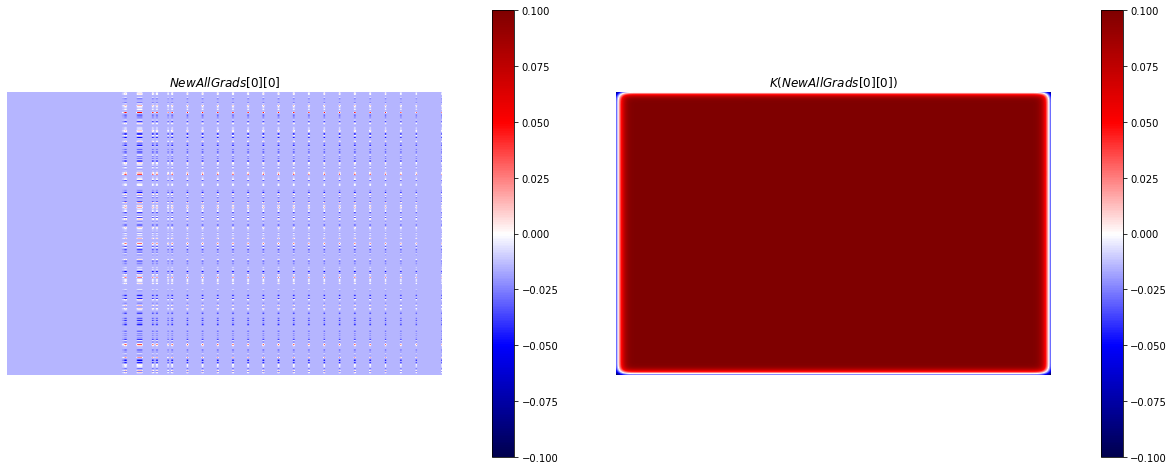

In [ ]:
#demo
plt.figure(figsize=(20,40))
plt.subplot(1,2,1)
plt.imshow(new_all_grads[0][0], cmap='seismic')
plt.colorbar(im,fraction=0.044, pad=0.1)
plt.title("$NewAllGrads[0][0]$")
plt.axis('off');
plt.subplot(1,2,2)
plt.imshow(K(new_all_grads[0][0]), cmap='seismic')
plt.colorbar(im,fraction=0.044, pad=0.1)
plt.title("$K(NewAllGrads[0][0])$")
plt.axis('off');

In [ ]:
plt.figure(figsize=(20,40))
plt.subplot(1,2,1)
plt.imshow(new_all_grads[0][4], cmap='seismic')
plt.colorbar(im,fraction=0.044, pad=0.1)
plt.title("$NewAllGrads[0][0]$")
plt.axis('off');
plt.subplot(1,2,2)
plt.imshow(K(new_all_grads[0][4]), cmap='seismic')
plt.colorbar(im,fraction=0.044, pad=0.1)
plt.title("$K(NewAllGrads[0][0])$")
plt.axis('off');

In [ ]:
R=samples_num

In [ ]:
lambd = np.ones(R)/R

In [ ]:
v = np.ones([N0,N1,R])
u = np.copy(v)

In [ ]:
for k in range(R):
    u[:,:,k] = new_all_grads[k][0]/K(v[:,:,k])

## 找 $K^{T}$

In [ ]:
#K_ = lambda x: np.dot(np.dot(K1,x),K1)
K = lambda x: np.dot(np.dot(K0,x),K1)
KT = lambda x: np.dot(np.dot(K0,x),K1)
b = np.zeros((N0,N1))
print(np.shape(b))
for k in range(1):
    #b = b + lambd[k] * np.log(np.maximum(1e-19*np.ones(np.shape(v[:,:,k])), v[:,:,k]*K(u[:,:,k])))
    print(np.shape(u[:,:,k]))
    #print(np.shape(K1))
    print(np.shape(KT(u[:,:,k])))
    print(np.shape(b) == np.shape(KT(u[:,:,k])))
# b = np.exp(b)

In [ ]:
N = 200
temp0 = torch.ones(N)
temp1 = torch.ones(N)
print(temp0.shape,temp0[:,None].shape)

torch.Size([200]) torch.Size([200, 1])


In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(b,cmap='seismic');
plt.colorbar(im,fraction=0.044, pad=0.1)
plt.axis('off');

In [ ]:
for k in range(R):
    v[:,:,k] = b/KT(u[:,:,k])

In [ ]:
def Wasserstein_barycentre_even(layer_size, layer_num, niter, samples_num, this_layer_part_grad):
    t0 = np.linspace(0, 1, layer_size[0])
    [Y0, X0] = np.meshgrid(t0, t0)
    K0 = np.exp(-(X0 - Y0) ** 2 / epsilon)
    K0 = torch.from_numpy(K0).type(torch.FloatTensor).to(device)
    t1 = np.linspace(0, 1, layer_size[1])
    [Y1, X1] = np.meshgrid(t1, t1)
    K1 = np.exp(-(X1 - Y1) ** 2 / epsilon)
    K1 = torch.from_numpy(K1).type(torch.FloatTensor).to(device)
    K = lambda x: (K0 @ x) @ K1
    v = torch.ones((layer_size[0], layer_size[1], samples_num)).to(device)
    u = np.copy(v)
    Err_q = torch.zeros(niter)
    lambd = torch.ones(samples_num) / samples_num
    for i in range(niter):

        for k in range(samples_num):
            Err_q[i] = Err_q[i] + torch.norm(u[:, :, k] * K(v[:, :, k]) - this_layer_part_grad[:,:,k], p=1)
            u[:, :, k] = this_layer_part_grad[:,:,k] / K(v[:, :, k])

        b = torch.zeros((layer_size[0], layer_size[1])).to(device)
        for k in range(samples_num):
            b = b + lambd[k] * torch.log(torch.maximum(1e-19 * torch.ones(np.shape(v[:, :, k])), v[:, :, k] * K(u[:, :, k])))
        b = torch.exp(b)

        for k in range(samples_num):
            v[:, :, k] = b / K(u[:, :, k])

    plt.figure(figsize=(7, 5))
    plt.plot(np.log(Err_q), linewidth=2)
    plt.show()
    return b

In [ ]:
def Wasserstein_barycentre(layer_num, niter, samples_num, new_all_grads):
    if layer_num != 4:
        epsilon = (.003) ** 2
    else:
        epsilon = (.06) ** 2
    N0 = np.shape(new_all_grads[0][layer_num])[0]
    N1 = np.shape(new_all_grads[0][layer_num])[1]
    t0 = np.linspace(0,1,N0)
    [Y0,X0] = np.meshgrid(t0,t0)
    K0 = np.exp(-(X0-Y0)**2/epsilon)
    K0 = torch.from_numpy(K0).type(torch.FloatTensor).to(device)
    t1 = np.linspace(0,1,N1)
    [Y1,X1] = np.meshgrid(t1,t1)
    K1 = np.exp(-(X1-Y1)**2/epsilon)
    K1 = torch.from_numpy(K1).type(torch.FloatTensor).to(device)
    K = lambda x: (K0 @ x) @ K1
    KT = lambda x: (K0.T @ x) @ K1.T
    v = np.ones([N0, N1, samples_num])
    u = np.copy(v)
    v = torch.from_numpy(v).type(torch.FloatTensor).to(device)
    u = torch.from_numpy(u).type(torch.FloatTensor).to(device)
    Err_q = torch.zeros(niter)
    lambd = torch.ones(samples_num)/samples_num

    for i in range(niter):

        for k in range(samples_num):
            a = torch.from_numpy(new_all_grads[k][layer_num]).type(torch.FloatTensor).to(device)
            Err_q[i] = Err_q[i] + torch.norm(u[:, :, k] * K(v[:, :, k]) - a, p=1)
            u[:, :, k] = a / K(v[:, :, k])

        b = torch.zeros((N0, N1)).to(device)
        for k in range(samples_num):
            b = b + lambd[k] * torch.log(max_tensor(1e-19 * torch.ones(np.shape(v[:, :, k])), v[:, :, k] * K(u[:, :, k])))
        b = torch.exp(b)

        for k in range(samples_num):
            v[:, :, k] = b / K(u[:, :, k])

    plt.figure(figsize=(7, 5))
    plt.plot(np.log(Err_q), linewidth=2)
    plt.show()
    b = b.cpu().detach().numpy().copy()
    return b

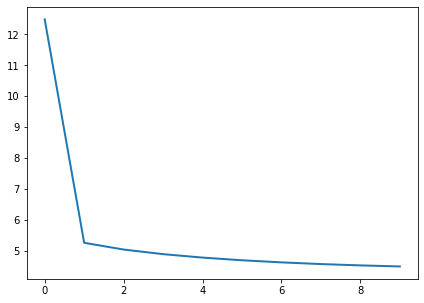

In [ ]:

#demo for 10 iteration (60min for 6 layers)
# niter = 10
# v = np.ones([N0,N1,R])
# u = np.copy(v)
# Err_q = np.zeros(niter)

# for i in range(niter):

#     for k in range(R):
#         Err_q[i] = Err_q[i] + linalg.norm(u[:,:,k]*K(v[:,:,k]) - new_all_grads[k][0], 1)
#         u[:,:,k] = new_all_grads[k][0]/K(v[:,:,k])

#     b = np.zeros((N0,N1))
#     for k in range(R):
#         b = b + lambd[k] * np.log(np.maximum(1e-19*np.ones(np.shape(v[:,:,k])), v[:,:,k]*K(u[:,:,k])))
#     b = np.exp(b)

#     for k in range(R):
#         v[:,:,k] = b/K(u[:,:,k])

# plt.figure(figsize=(7,5))
# plt.plot(np.log(Err_q),linewidth = 2)
# plt.show()

In [ ]:
def back(global_all_grad, global_min):
    new_global_all_grad = []
    for i in range(len(global_all_grad)):
        new_global_all_grad.append(global_all_grad[i] - np.abs(global_min))
    return new_global_all_grad

In [ ]:
new_global_all_grad = back(global_all_grad, global_min)
for i in range(len(new_global_all_grad)):
    print(new_global_all_grad[i].min())

fig, axes = plt.subplots(2,3,figsize=(30,20))
for nump in range(len(new_global_all_grad)):
  i = int(nump/3)
  j = int(nump%3)
  im = axes[i,j].imshow(new_global_all_grad[nump], cmap='seismic', vmin=-0.1, vmax=0.1)
  plt.colorbar(im,fraction=0.044, pad=0.1,ax =axes[i,j] )

In [ ]:
fig, axes = plt.subplots(2,3,figsize=(30,20))
for nump in range(len(new_global_all_grad)):
  i = int(nump/3)
  j = int(nump%3)
  im = axes[i,j].imshow(new_global_all_grad[nump], cmap='seismic', vmin=-0.1, vmax=0.1)
  plt.colorbar(im,fraction=0.044, pad=0.1,ax =axes[i,j] )

In [ ]:
# 把所有的weight & bais 拆回来
# 所有local gradients的集合
global_all_grads = []
for nump in range(0, params_num):
    # 把weights和bais拆开
    param_all_grads = np.zeros_like(all_grads[0][nump])
    if nump % 2 == 0:
        for i in range(np.shape(all_grads[0][nump])[0]):
            for j in range(np.shape(all_grads[0][nump])[1]):
                param_all_grads[i][j] = new_global_all_grad[int(nump/2)][i][j]
    else:
        for i in range(np.shape(all_grads[0][nump])[0]):
            param_all_grads[i] = new_global_all_grad[int(nump/2)][i][-1]

    global_all_grads.append(param_all_grads)

In [ ]:
def assign_back(autoencoder, global_all_grads, params_num, lr=0.001):
    # get global_all_grad[i] for all layers
    for param, i in zip(autoencoder.parameters(), range(params_num)):
        improve = lr * global_all_grads[i]
        improve = torch.from_numpy(improve)
        improve = improve.to(device)
        param = param + improve

    return None


In [ ]:
assign_back(autoencoder, global_all_grads, params_num)

In [ ]:
def train(autoencoder,data, niter=100, epochs=1):
    for epoch in range(epochs):
        params_num, samples_num, all_grads = calculate_grads(autoencoder, data)
        # 所有local gradients的集合
        new_all_grads = []
        for num in range(samples_num):
            # 每个sample的gradient的集合
            new_sample_grad = []
            for nump in range(0, params_num, 2):
                # 把weights和bais合并
                new_param_grad = np.zeros((np.shape(all_grads[num][nump])[0], np.shape(all_grads[num][nump])[1] + 1))
                for i in range(np.shape(all_grads[num][nump])[0]):
                    for j in range(np.shape(all_grads[num][nump])[1]):
                        new_param_grad[i][j] = all_grads[num][nump][i][j]
                for i in range(np.shape(all_grads[num][nump])[0]):
                    new_param_grad[i][-1] = all_grads[num][nump + 1][i]
                new_sample_grad.append(new_param_grad)
            new_all_grads.append(new_sample_grad)
        # sample 0
        fig, axes = plt.subplots(2, 3, figsize=(30, 20))
        for nump in range(int(params_num / 2)):
            i = int(nump / 3)
            j = int(nump % 3)
            im = axes[i, j].imshow(new_all_grads[0][nump], cmap='seismic', vmin=-0.1, vmax=0.1)
            plt.colorbar(im, fraction=0.044, pad=0.1, ax=axes[i, j])

        global_min = all_positive(new_all_grads, samples_num, params_num)

        global_all_grad = []
        for i in range(np.shape(new_all_grads)[1]):
            global_all_grad.append(Wasserstein_barycentre(i, niter, samples_num, new_all_grads))
        
        new_global_all_grad = back(global_all_grad, global_min)
        for i in range(len(new_global_all_grad)):
            print(new_global_all_grad[i].min())

        fig, axes = plt.subplots(2, 3, figsize=(30, 20))
        for nump in range(len(new_global_all_grad)):
            i = int(nump / 3)
            j = int(nump % 3)
            im = axes[i, j].imshow(new_global_all_grad[nump], cmap='seismic', vmin=-0.1, vmax=0.1)
            plt.colorbar(im, fraction=0.044, pad=0.1, ax=axes[i, j])
        
        global_all_grads = []
        for nump in range(0, params_num):
            # 把weights和bais拆开
            param_all_grads = np.zeros_like(all_grads[0][nump])
            if nump % 2 == 0:
                for i in range(np.shape(all_grads[0][nump])[0]):
                    for j in range(np.shape(all_grads[0][nump])[1]):
                        param_all_grads[i][j] = new_global_all_grad[int(nump / 2)][i][j]
            else:
                for i in range(np.shape(all_grads[0][nump])[0]):
                    param_all_grads[i] = new_global_all_grad[int(nump / 2)][i][-1]

            global_all_grads.append(param_all_grads)
        
        assign_back(autoencoder, global_all_grads, params_num)

    return autoencoder

In [ ]:
#without print version
def train(autoencoder,data, kl_div_on=True, epochs=1):
    for epoch in range(epochs):
        params_num, samples_num, all_grads = calculate_grads(autoencoder, data)
        # 所有local gradients的集合
        new_all_grads = []
        for num in range(samples_num):
            # 每个sample的gradient的集合
            new_sample_grad = []
            for nump in range(0, params_num, 2):
                # 把weights和bais合并
                new_param_grad = np.zeros((np.shape(all_grads[num][nump])[0], np.shape(all_grads[num][nump])[1] + 1))
                for i in range(np.shape(all_grads[num][nump])[0]):
                    for j in range(np.shape(all_grads[num][nump])[1]):
                        new_param_grad[i][j] = all_grads[num][nump][i][j]
                for i in range(np.shape(all_grads[num][nump])[0]):
                    new_param_grad[i][-1] = all_grads[num][nump + 1][i]
                new_sample_grad.append(new_param_grad)
            new_all_grads.append(new_sample_grad)
        global_min = all_positive(new_all_grads, samples_num, params_num)
        global_all_grad = []
        for i in range(np.shape(new_all_grads)[1]):
            global_all_grad.append(Wasserstein_barycentre(i, 2, samples_num, new_all_grads))
        new_global_all_grad = back(global_all_grad, global_min)
        global_all_grads = []
        for nump in range(0, params_num):
            # 把weights和bais拆开
            param_all_grads = np.zeros_like(all_grads[0][nump])
            if nump % 2 == 0:
                for i in range(np.shape(all_grads[0][nump])[0]):
                    for j in range(np.shape(all_grads[0][nump])[1]):
                        param_all_grads[i][j] = new_global_all_grad[int(nump / 2)][i][j]
            else:
                for i in range(np.shape(all_grads[0][nump])[0]):
                    param_all_grads[i] = new_global_all_grad[int(nump / 2)][i][-1]

            global_all_grads.append(param_all_grads)
        assign_back(autoencoder, global_all_grads, params_num)

    return autoencoder

In [ ]:
autoencoder2 = train(autoencoder,data, niter=100, epochs=10)

In [ ]:
def plot_2D_latent_space(autoencoder, data, num_batches=100):
    '''
    Plot a the latent vector for a lots of images
    '''
    for n , (x, y) in enumerate(data):  # enumerate means n = n + 1 per iteration. x is the batch of images, y are the class labels
        z = autoencoder.latentIn(autoencoder.encoder(x.to(device)))  # Run the batch through the Encoder and Latent input layer
        z = z.to('cpu').detach().numpy()  # Send latent vector to cpu
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')  # Scatter plot of latent vector colourised by the class label y
        if n > num_batches:  # stop after n > maximum number of batches
          plt.colorbar()
          break

def plot_2D_latent_sample(autoencoder, image):
    '''
    Plot a the latent vector for a single image
    '''
    z = autoencoder.latentIn(autoencoder.encoder(image.to(device)))  # Run the image through the Encoder and Latent input layer
    z = z.to('cpu').detach().numpy()  # Send latent vector to cpu
    plt.scatter(z[:, 0], z[:, 1], marker='x', c='k')  # Scatter plot of latent vector

plot_2D_latent_space(autoencoder, data)
plt.show()

x,y = next(iter(data)) # Get next iteration from data iterator
print(y)

n = 0  # Choose a label
print(y[n]) # Print out chose label

image = x[n]
plt.figure()
plot_2D_latent_space(autoencoder2, data)
plot_2D_latent_sample(autoencoder2, image)

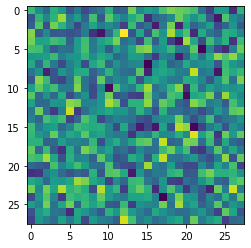

tensor([-10.,   5.], device='cuda:0')


In [ ]:
def plot_sample(autoencoder, z):
    img = autoencoder.decoder(autoencoder.activationOut(autoencoder.latentOut(z))).to('cpu').detach().numpy()[0,0]
    plt.imshow(img)
    plt.show()
    print(z)

z = torch.tensor([-10, 5]).to(device).float()
plot_sample(autoencoder2, z)

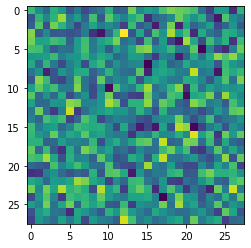

tensor([-10.,   5.], device='cuda:0')


In [ ]:
plot_sample(autoencoder, z)

In [ ]:
print(autoencoder==autoencoder2)

In [ ]:
autoencoder2 = train(autoencoder,data, kl_div_on=True, epochs=2)

# *****ENDING***********************************

## 1.5 Training

We train the Autoencoder by stocastic gradient descent, you have seen this process several times in different forms. My implementation of this process is below:

In [ ]:
def train(autoencoder, data, kl_div_on=True, epochs=10):
  opt = torch.optim.Adam(autoencoder.parameters())
  for epoch in range(epochs):  # Run data over numerous epochs
    for batch, label in data:  # Iterate over the batches of images and labels
      batch = batch.to(device)  # Send batch of images to the GPU
      opt.zero_grad()  # Set optimiser grad to 0
      x_hat = autoencoder(batch)  # Generate predicted images (x_hat) by running batch of images through autoencoder
      loss = ((batch - x_hat)**2).sum()  # Calculate L2 loss
      loss.backward()  # Back-propagate
      opt.step()  # Step the optimiser
  return autoencoder  # Return the trained autoencoder (for later analysis)


dims_latent = 2  # Maybe increase this an try the t-sne algorithm for visualisation?!
autoencoder = Autoencoder(dims_latent).to(device)
autoencoder = train(autoencoder, data, 10)

print('done')

done


## 1.6 Latent space visualisation

Have a look at the latent space before and after training.


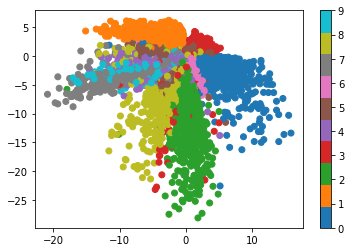

tensor([5, 1, 8, 0, 2, 7, 7, 6, 0, 4, 0, 7, 5, 3, 3, 9, 0, 9, 0, 5, 4, 6, 1, 3,
        2, 5, 8, 3, 2, 3, 4, 5, 8, 8, 4, 5, 8, 7, 8, 9, 6, 9, 9, 1, 4, 2, 2, 9,
        3, 7, 1, 3, 6, 7, 9, 2, 5, 1, 9, 9, 4, 8, 2, 1, 2, 6, 2, 9, 6, 4, 0, 8,
        8, 2, 6, 9, 0, 1, 5, 9, 1, 7, 8, 2, 8, 8, 4, 0, 0, 2, 5, 2, 1, 3, 8, 1,
        3, 8, 1, 9, 2, 6, 4, 8, 5, 4, 6, 7, 4, 5, 1, 5, 7, 8, 6, 8, 3, 6, 9, 0,
        8, 6, 4, 6, 9, 3, 8, 1])
tensor(5)


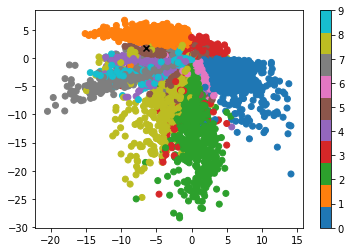

In [ ]:
def plot_2D_latent_space(autoencoder, data, num_batches=100):
    '''
    Plot a the latent vector for a lots of images
    '''
    for n , (x, y) in enumerate(data):  # enumerate means n = n + 1 per iteration. x is the batch of images, y are the class labels
        z = autoencoder.latentIn(autoencoder.encoder(x.to(device)))  # Run the batch through the Encoder and Latent input layer
        z = z.to('cpu').detach().numpy()  # Send latent vector to cpu
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')  # Scatter plot of latent vector colourised by the class label y
        if n > num_batches:  # stop after n > maximum number of batches
          plt.colorbar()
          break

def plot_2D_latent_sample(autoencoder, image):
    '''
    Plot a the latent vector for a single image
    '''
    z = autoencoder.latentIn(autoencoder.encoder(image.to(device)))  # Run the image through the Encoder and Latent input layer
    z = z.to('cpu').detach().numpy()  # Send latent vector to cpu
    plt.scatter(z[:, 0], z[:, 1], marker='x', c='k')  # Scatter plot of latent vector

plot_2D_latent_space(autoencoder, data)
plt.show()

x,y = next(iter(data)) # Get next iteration from data iterator
print(y)

n = 0  # Choose a label
print(y[n]) # Print out chose label

image = x[n]
plt.figure()
plot_2D_latent_space(autoencoder, data)
plot_2D_latent_sample(autoencoder, image)

## 1.7 Generate new images

We need to see what our generative model can do! Lets take some random samples from the latent space and see what our model produces.

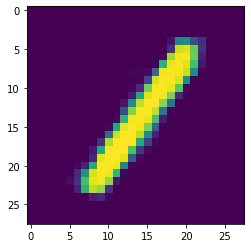

tensor([-10.,   5.], device='cuda:0')


<Figure size 432x288 with 0 Axes>

In [ ]:
def plot_sample(autoencoder, z):
    img = autoencoder.decoder(autoencoder.activationOut(autoencoder.latentOut(z))).to('cpu').detach().numpy()[0,0]
    plt.imshow(img)
    plt.show()
    plt.savefig("/content/drive/MyDrive/practial6/generated_image.jpg")  # Save the figure to google drive!
    print(z)

z = torch.tensor([-10, 5]).to(device).float()
plot_sample(autoencoder, z)

## 1.8 Generate interpolation grids 

Looking at random samples is all very well, what we really want to see is whether the labels in the latent space acutally generate what we expect. Plot a grid showing the outputs of different parts of the latent space. 

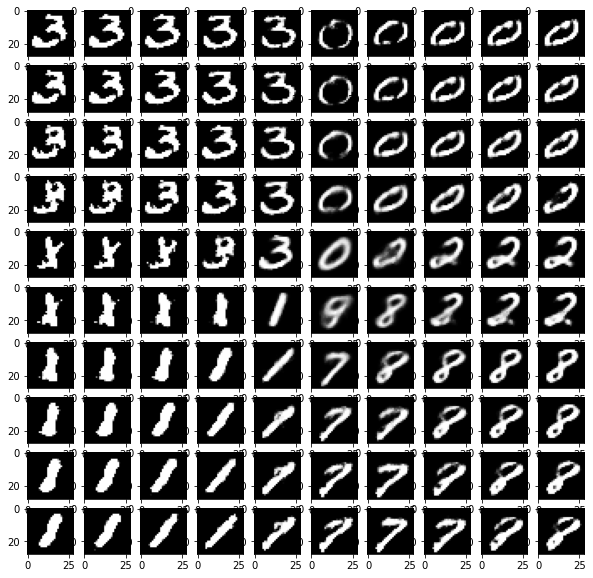

In [ ]:
def plot_grid(autoencoder, n=(10, 10), param_range=(-3, 3)):
  x_range = torch.linspace(param_range[0], param_range[1], n[0])
  y_range = torch.linspace(param_range[0], param_range[1], n[1])
  grid_y, grid_x = torch.meshgrid(x_range, y_range)
  
  z = torch.zeros(2,n[0]*n[1])
  z[1] = grid_x.reshape(n[0]*n[1],1).squeeze()
  z[0] = grid_y.reshape(1,n[0]*n[1]).permute(1,0).flip(1).squeeze()
  z = z.to(device)

  fig, axarr = plt.subplots(n[0], n[1], figsize=(10, 10))
  im_s = np.zeros((n[0]*n[1], 28**2))
  for n in range(0,n[0]*n[1]):
    decoder_input = autoencoder.activationOut(autoencoder.latentOut(z[:,n]))
    im_s[-n-1,:] = autoencoder.decoder(decoder_input).flatten().to('cpu').detach().numpy()

  for ax, img in zip(axarr.flatten(), im_s):
    ax.imshow(img.reshape(28,28), cmap="gray")

plot_grid(autoencoder, param_range=(-50, 50))

# 2 The Variational Autoencoder

This tutorial will teach you to build a **Variational Autoencoder** (VAE) which is capable of generating handwritten digits after training on the MNIST dataset. 

In the Theory session you learnt that VAE's and Autoencoders are identical in structure apart from in their latent space, which we force to be a distribution of our choosing. The following diagram shows the VAE which also uses the reparameterisation trick, which is the most common approach to enable VAE training. An alternative approach **does not** use the reparameterisation trick and the set-up will be identical to the autoencoder above, but in this case the gradient of the loss-function should use the log-derivative trick.

NOTE, I've put standard deviation by accident, this should say variance!

![VAE_Diagram.jpg](https://raw.githubusercontent.com/acse-2020/ACSE-8/main/implementation/practical_6/morning_lecture/Figs/VAE_Diagram.jpg?token=ABNZJP5SKEMRQFIKPKNFJCTAU22Q6)

## 2.1 Questions

Given than our autoencoder will use a mean-field gaussian latent space, what are the parameters of our latent distribution?

1.  Mean ($\mu$) and variance ($\Sigma$) per pixel
2.  Mean ($\mu$) and variance ($\Sigma$) per dimension of the latent space
1.  Mean ($\mu$) and covariance ($\Sigma$) for the whole image
2.  Mean ($\mu$) and covariance ($\Sigma$) for the whole latent vector

## 2.2 Encoder 

The set-up of the Encoder will be identical to the Autoencoder architecture


In [ ]:
class VAE_Encoder(nn.Module):  # The Encoder inherits the properties of nn.Module https://pytorch.org/docs/stable/generated/torch.nn.Module.html
  def __init__(self):
    '''
    Class contains the Encoder (image -> latent).
    '''

    super(VAE_Encoder, self).__init__()
    self.layer0 = nn.Linear(784, 512)  # Image to hidden, fully connected
    self.transform0 = nn.ReLU()
    self.layer1 = nn.Linear(512, 256)  # Image to hidden, fully connected
    self.transform1 = nn.ReLU()

  def forward(self, x):  # Custom pytorch modules should follow this structure 
    '''
    x: [float] the MNIST image
    '''

    x = torch.flatten(x, start_dim = 1)  # Reshape the input into a vector (nD to 1D) 
    x = self.transform0(self.layer0(x))  # Run Image through Linear transform then ReLu activation function
    x = self.transform1(self.layer1(x))  # Run Image through Linear transform then ReLu activation function
    return x


## 2.3 Decoder 

The set-up of the Encoder will be identical to the Autoencoder architecture


In [ ]:
class VAE_Decoder(nn.Module):
  def __init__(self):
    '''
    Class contains the Decoder (latent -> image).
    '''

    super(VAE_Decoder, self).__init__()
    self.layer1 = nn.Linear(256, 512)  # Connectivity Latent to Hidden
    self.activation1 = nn.ReLU()
    self.layerOut = nn.Linear(512, 784)  # Connectivity Hidden to Image
    self.activationOut = nn.Sigmoid()

  def forward(self, z):
    '''
    z: [float] a sample from the latent variable
    '''

    z = self.activation1(self.layer1(z))  # Run Image through Linear transform then ReLu activation function
    z = self.activationOut(self.layerOut(z))  # Run Image through Linear transform then Sigmoid activation function
    return  z.reshape((-1,1,28,28))  # Reshape the vector into an image

print('done')

done


## 2.4 Variational Autoencoder

The VAE structure also inherits from the Encoder and the Decoder. The forward module of the VAE should take and image, run the encoder (image -> latent) then run the decoder to make a prediction (latent -> generated image).

The VAE is below, and the latent space will have variable dimensionality. We will use the Reparameterisation trick in our VAE.

In [ ]:
class VariationalAutoencoder(nn.Module):
  def __init__(self, dims_latent):
    '''
    Class combines the Encoder and the Decoder.

    dims_latent: [int] the dimension of (number of nodes in) the mean-field gaussian latent variable
    '''
    
    super(VariationalAutoencoder, self).__init__()
    self.encoder = VAE_Encoder()
    self.decoder = VAE_Decoder()

    self.layerMu = nn.Linear(256, dims_latent)  # Hidden to latent, fully connected
    self.layerSig = nn.Linear(256, dims_latent)  # Hidden to latent, fully connected
    self.distribution = torch.distributions.Normal(0, 1)  # Sample from N(0,1)

    self.latentOut = nn.Linear(dims_latent, 256)  # Connectivity Latent to Hidden
    self.activationOut = nn.ReLU()


  def vae_latent_space(self, x):
    mu =  self.layerMu(x)  # Turn the output of the Encoder into Mu
    sigma = torch.exp(self.layerSig(x))  # Exponential activation ensures positivity for Sigma
    z = mu + sigma * self.distribution.sample(mu.shape).to(device)
    kl_div = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
    return z, kl_div

  def forward(self, x):
    x = self.encoder(x)
    z, kl_div = self.vae_latent_space(x)
    z = self.activationOut(self.latentOut(z))  # Take the latent vector and make the input for the Decoder
    return self.decoder(z), kl_div

print('done')

done


## 2.5 Training

Once we have a VAE which contains the re-parameterised latent space, we can train as previous.

**The KL divergence between the prior and approximating distribution is crucial here, you should try training when you zero-out the KL divergence ans see what happens to the latent space (it won't be gaussian anymore!)**

In [ ]:
def train(autoencoder, data, kl_div_on=True, epochs=10):
  opt = torch.optim.Adam(autoencoder.parameters())
  for epoch in range(epochs):  # Run data over numerous epochs
    for batch, label in data:  # Iterate over the batches of images and labels
      batch = batch.to(device)  # Send batch of images to the GPU
      opt.zero_grad()  # Set optimiser grad to 0
      x_hat, KL = autoencoder(batch)  # Generate predicted images (x_hat) by running batch of images through autoencoder
      loss = ((batch - x_hat)**2).sum() + KL  # Calculate L2 loss
      loss.backward()  # Back-propagate
      opt.step()  # Step the optimiser
  return autoencoder  # Return the trained autoencoder (for later analysis)


dims_latent = 2  # Maybe increase this an try the t-sne algorithm for visualisation?!
VAE = VariationalAutoencoder(dims_latent).to(device)
VAE = train(VAE, data, 10)

print('done')

done


## 2.6 Latent space visualisation

Have a look at the latent space before and after training (a one tweak is needed).



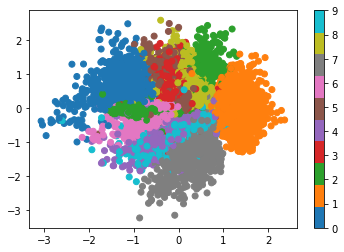

tensor([9, 1, 2, 6, 3, 0, 2, 8, 0, 3, 2, 1, 9, 3, 1, 6, 3, 1, 6, 9, 3, 2, 1, 6,
        5, 2, 9, 3, 3, 6, 7, 6, 1, 8, 5, 4, 1, 1, 5, 9, 1, 1, 7, 6, 0, 1, 4, 1,
        7, 9, 3, 5, 2, 7, 2, 0, 8, 7, 1, 7, 0, 8, 0, 7, 0, 3, 5, 1, 8, 8, 1, 6,
        4, 0, 9, 4, 5, 6, 2, 0, 0, 7, 4, 3, 9, 4, 8, 0, 6, 4, 2, 7, 9, 3, 6, 4,
        6, 6, 9, 6, 2, 2, 0, 3, 7, 7, 8, 6, 9, 3, 9, 3, 6, 1, 5, 2, 9, 3, 3, 4,
        7, 9, 5, 3, 6, 8, 2, 3])
tensor(9)


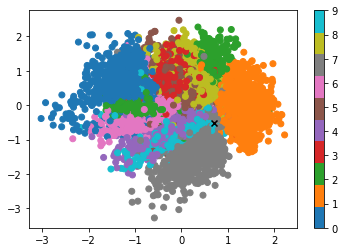

In [ ]:
def plot_2D_latent_space(autoencoder, data, num_batches=100):
    '''
    Plot a the latent vector for a lots of images
    '''
    for n , (x, y) in enumerate(data):  # enumerate means n = n + 1 per iteration. x is the batch of images, y are the class labels
        z, KL = autoencoder.vae_latent_space(autoencoder.encoder(x.to(device)))  # Run the batch through the Encoder and Latent input layer
        z = z.to('cpu').detach().numpy()  # Send latent vector to cpu
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')  # Scatter plot of latent vector colourised by the class label y
        if n > num_batches:  # stop after n > maximum number of batches
          plt.colorbar()
          break

def plot_2D_latent_sample(autoencoder, image):
    '''
    Plot a the latent vector for a single image
    '''
    z, KL = autoencoder.vae_latent_space(autoencoder.encoder(image.to(device)))  # Run the image through the Encoder and Latent input layer
    z = z.to('cpu').detach().numpy()  # Send latent vector to cpu
    plt.scatter(z[:, 0], z[:, 1], marker='x', c='k')  # Scatter plot of latent vector

plot_2D_latent_space(VAE, data)
plt.show()

x,y = next(iter(data)) # Get next iteration from data iterator
print(y)

n = 0  # Choose a label
print(y[n]) # Print out chose label

image = x[n]
plt.figure()
plot_2D_latent_space(VAE, data)
plot_2D_latent_sample(VAE, image)

## 2.7 Generate new images

Now we can generate new images BUT we can also determine the likelihood of a given image by sampling from the standard normal distribution $z_i \sim \mathcal{N}(0, \mathbf{I})$!

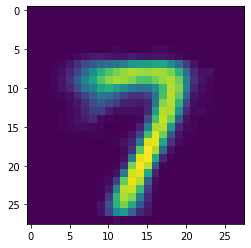

tensor([ 0.3622, -1.0774], device='cuda:0')


<Figure size 432x288 with 0 Axes>

In [ ]:
def plot_sample(autoencoder, z):
    img = autoencoder.decoder(autoencoder.activationOut(autoencoder.latentOut(z))).to('cpu').detach().numpy()[0,0]
    plt.imshow(img)
    plt.show()
    plt.savefig("/content/drive/MyDrive/practial6/generated_image.jpg")  # Save the figure to google drive!
    print(z)

z = torch.randn(2).to(device).float()
plot_sample(VAE, z)

# 3 Other learning resources

https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html

https://arxiv.org/abs/1606.05908

